# 190619_DBindex_Silscore_tutorial

This Jupyter notebook is related to my blogpost of how to evaluate clustering results when no gold standard is available. I simply followed Scanpy's tutorial (the first steps of this notebook are exactly the same as the publically posted tutorial: https://github.com/theislab/scanpy-tutorials/blob/master/pbmc3k.ipynb). I then just added in some lines testing different combinations of KNN and resolution parameters and how that would affect cluster numbers and associated scores (Silhouette Coefficient and the Davies-Bouldin index). The sckit-learn implementation was used for these two scores: https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient.

The following section is just copied from the standard tutorial:

In May 2017, this started out as a demonstration that Scanpy would allow to reproduce most of Seurat's ([Satija et al., 2015](https://doi.org/10.1038/nbt.3192)) [guided clustering tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html). We gratefully acknowledge the authors of Seurat for the tutorial. In the meanwhile, we have added and removed a few pieces.  
    
The data consists in *3K PBMCs from a Healthy Donor* and is freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/pbmc3k.h5ad'  # the file that will store the analysis results

scanpy==1.4 anndata==0.6.19 numpy==1.16.2 scipy==1.2.1 pandas==0.24.2 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
sc.settings.set_figure_params(dpi=80)

In [3]:
adata = sc.read_10x_mtx(
    './data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

... reading from cache file ./cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [4]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

In [5]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738 
    var: 'gene_ids'

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

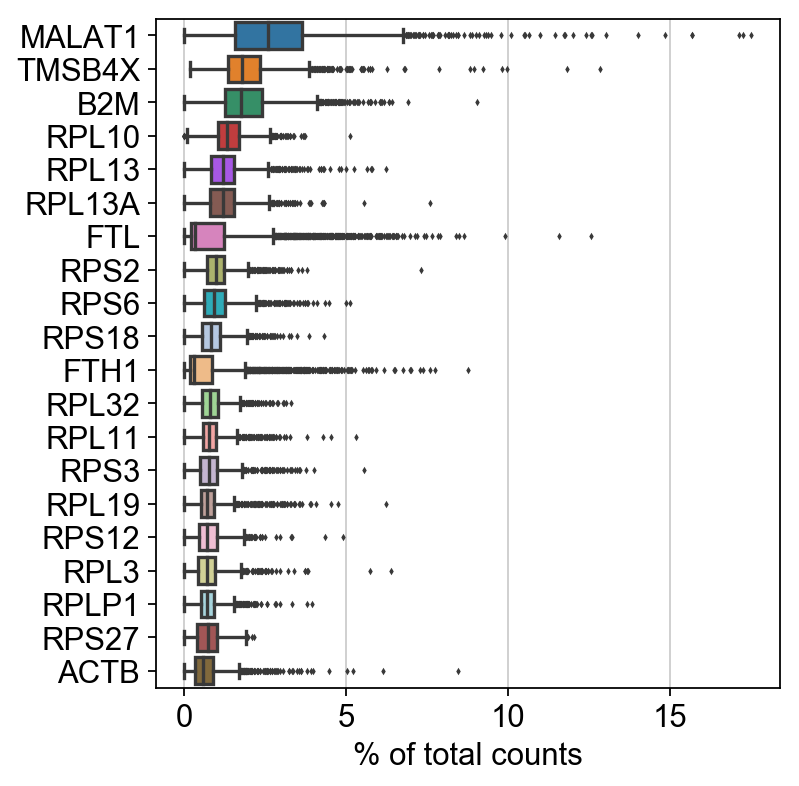

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20)

Basic filtering.

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


Let us assemple some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

Note you can also use the function `pp.calculate_qc_metrics` to compute the fraction of mitochondrial genes and additional measures.

In [8]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

A violin plot of the computed quality measures.

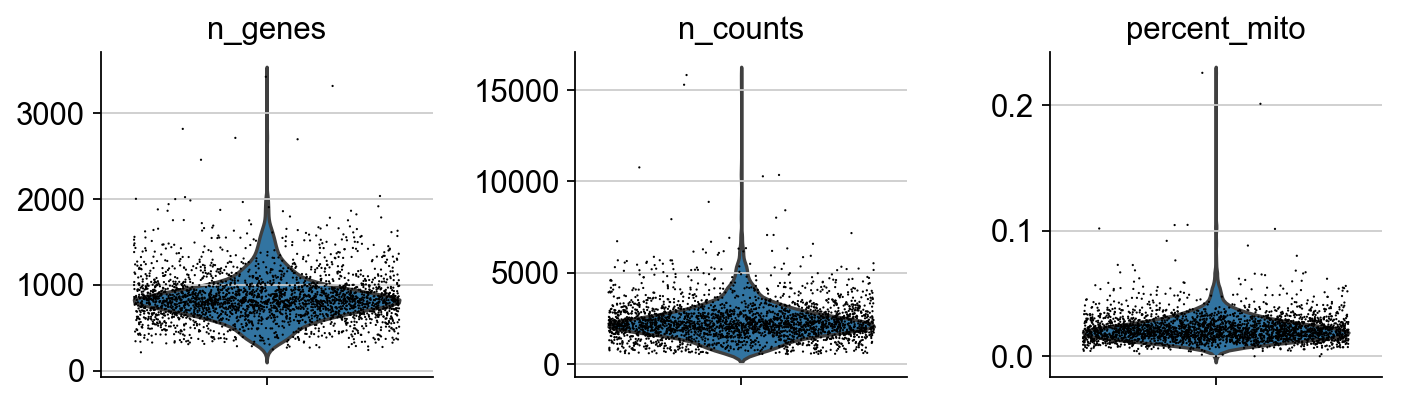

In [9]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

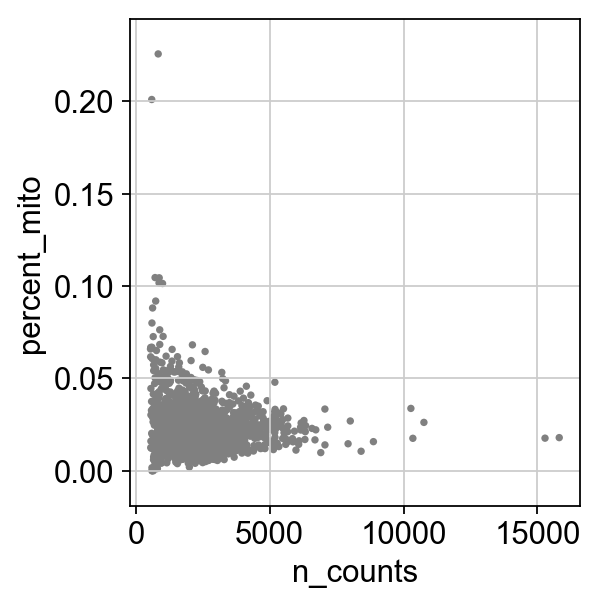

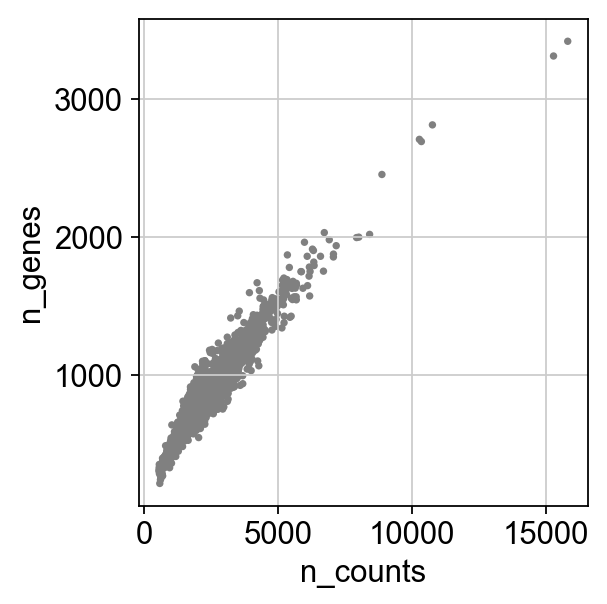

In [10]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [11]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

Actually do the filtering.

In [12]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [13]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

Logarithmize the data.

In [14]:
sc.pp.log1p(adata)

Set the `.raw` attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object. While many people consider the normalized data matrix as the "relevant data" for visualization and differential testing, some would prefer to store the unnormalized data.

In [15]:
adata.raw = adata

Identify highly-variable genes.

In [16]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


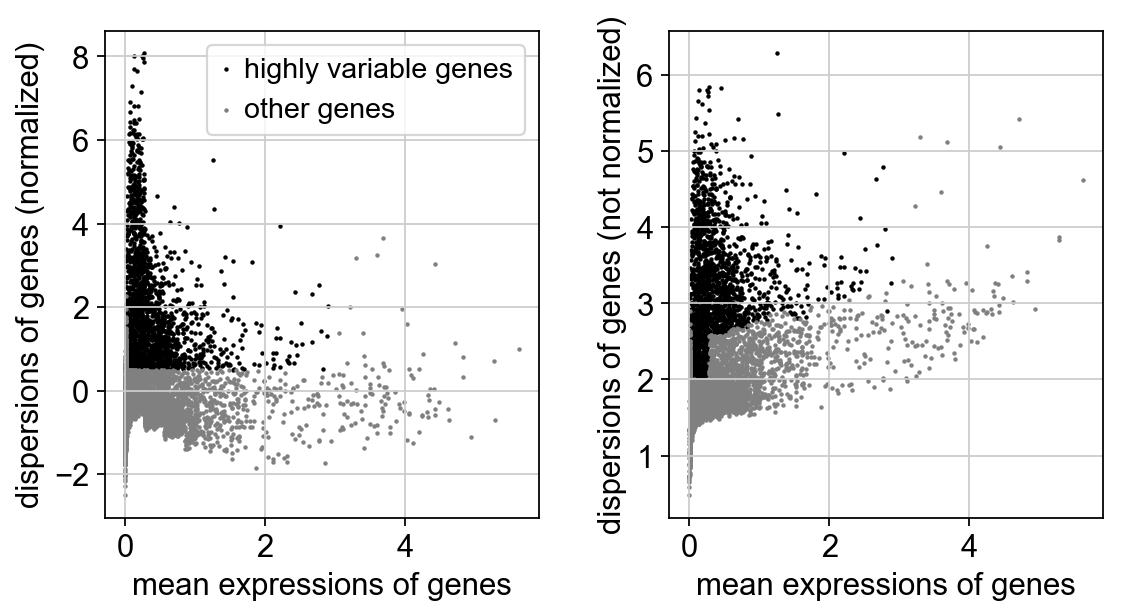

In [17]:
sc.pl.highly_variable_genes(adata)

Actually do the filtering.

In [18]:
adata = adata[:, adata.var['highly_variable']]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [19]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:20.28)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [20]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [21]:
sc.tl.pca(adata, svd_solver='arpack')

We can make a scatter plot in the PCA coordinates, but we will not use that later on.

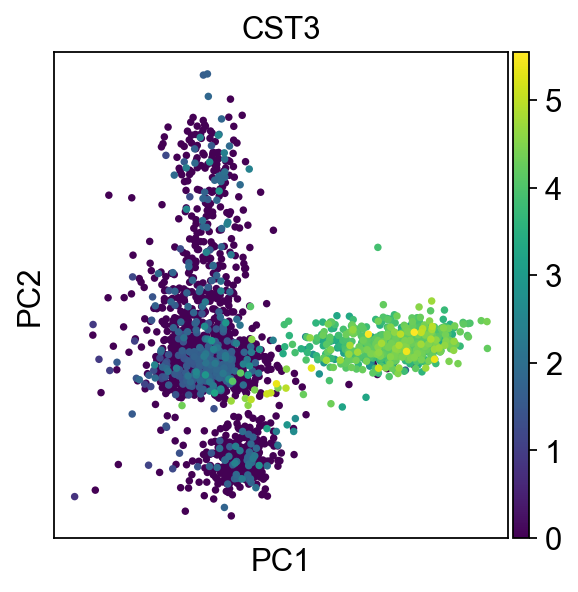

In [22]:
sc.pl.pca(adata, color='CST3')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

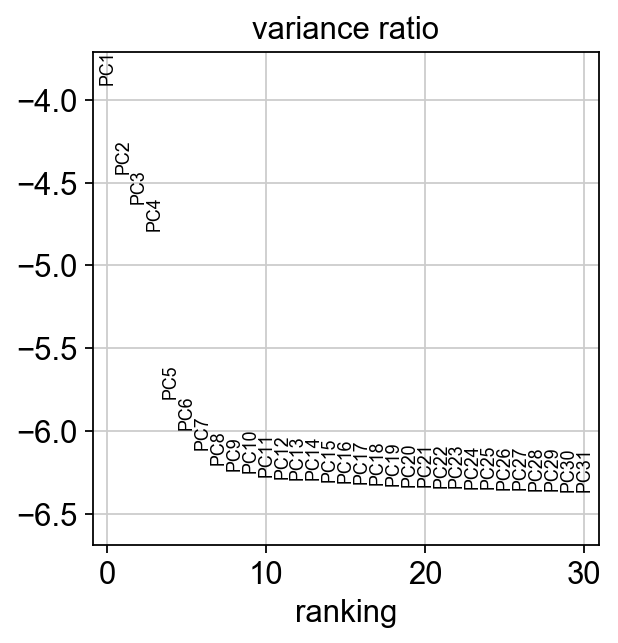

In [23]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

In [24]:
adata.write(results_file)

In [25]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [26]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:12.47) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


## Embedding the neighborhood graph

We advertise embedding the graph in 2 dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is  potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preservers trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [27]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:15.95) --> added
    'X_umap', UMAP coordinates (adata.obsm)


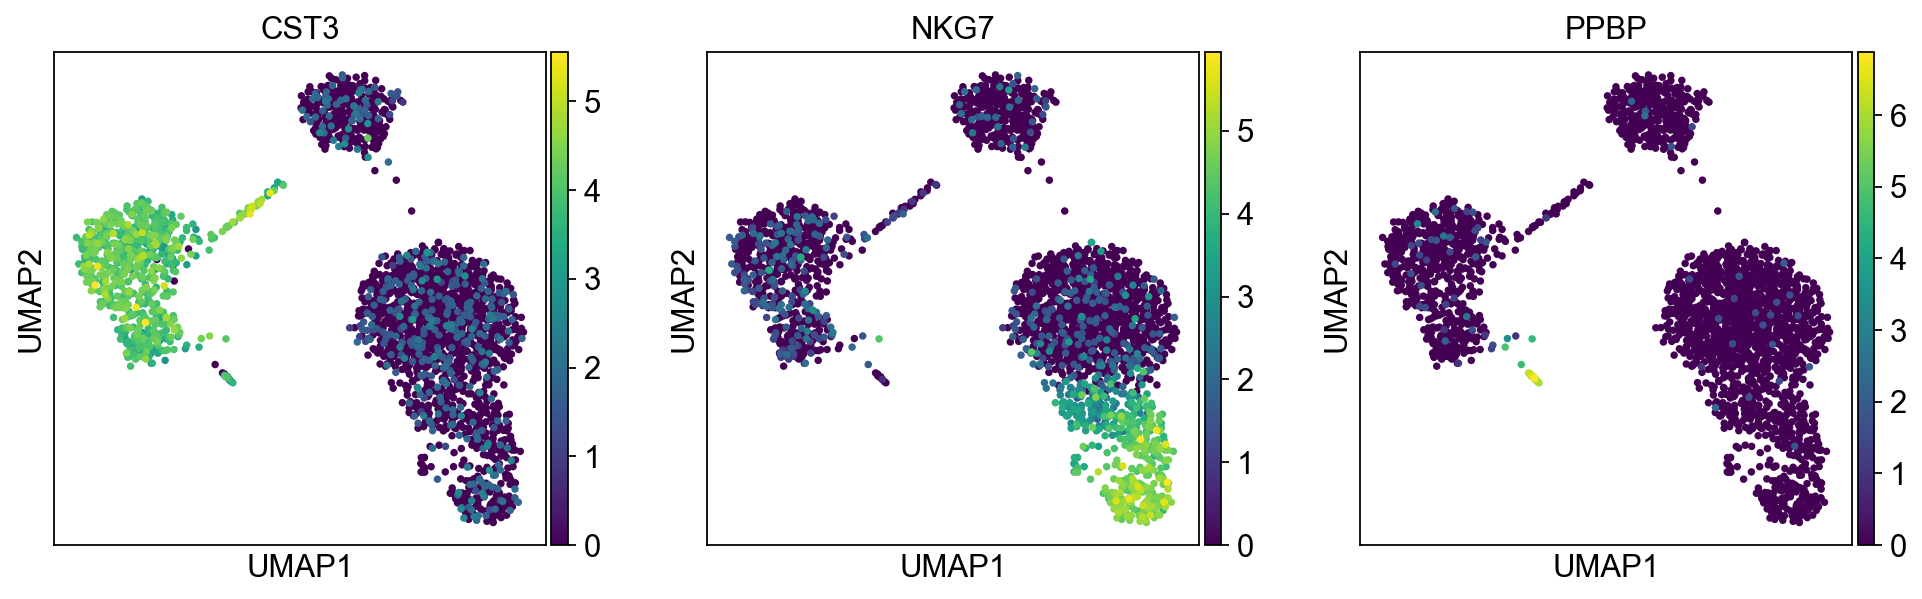

In [28]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

As we set the `.raw` attribute of `adata`, the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

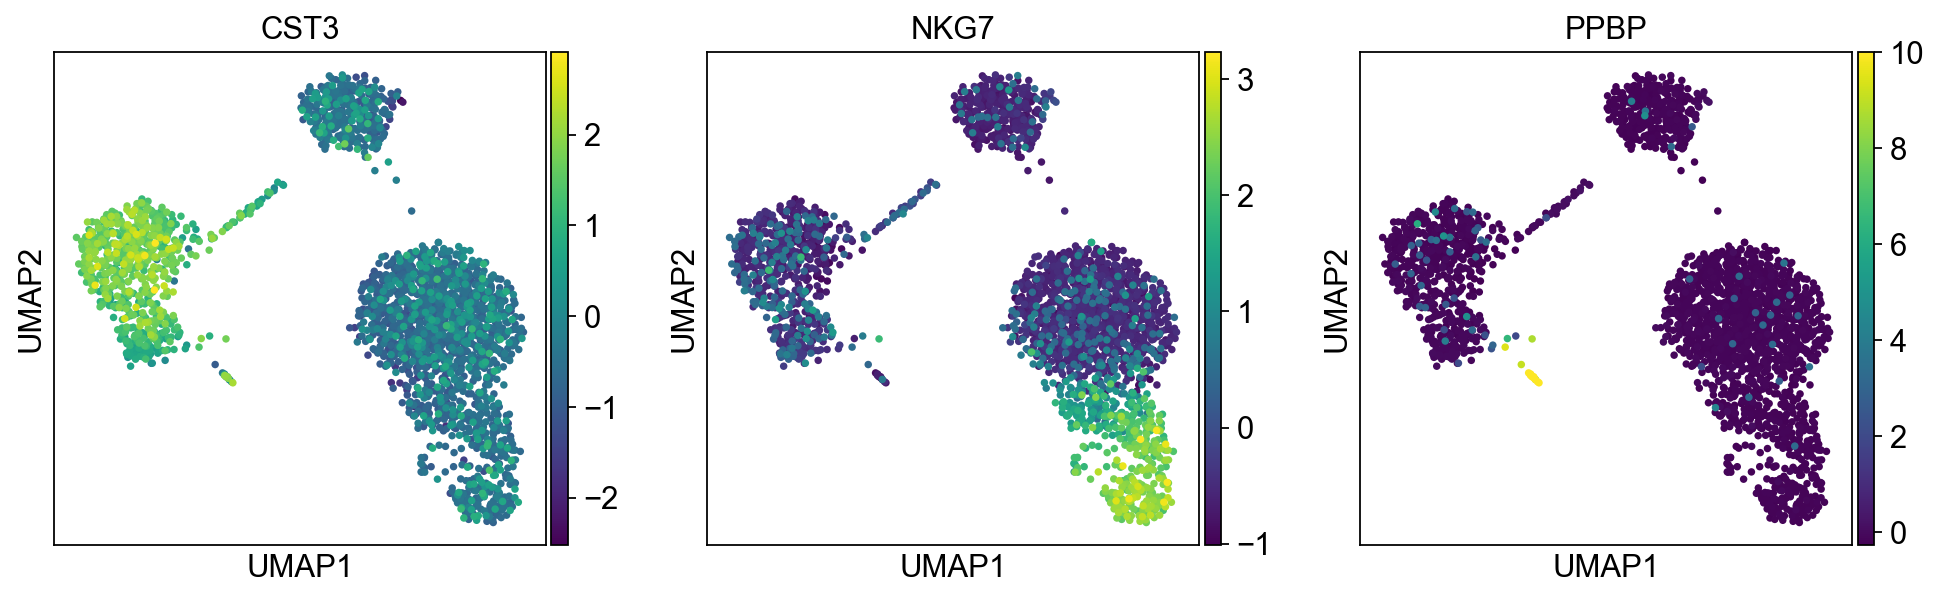

In [29]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

## Clustering the neighborhood graph

As Seurat and many others, we recommend the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by [Levine et al. (2015)](https://doi.org/10.1016/j.cell.2015.05.047). Note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [30]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.49) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


Plot the clusters, which agree quite well with the result of Seurat.

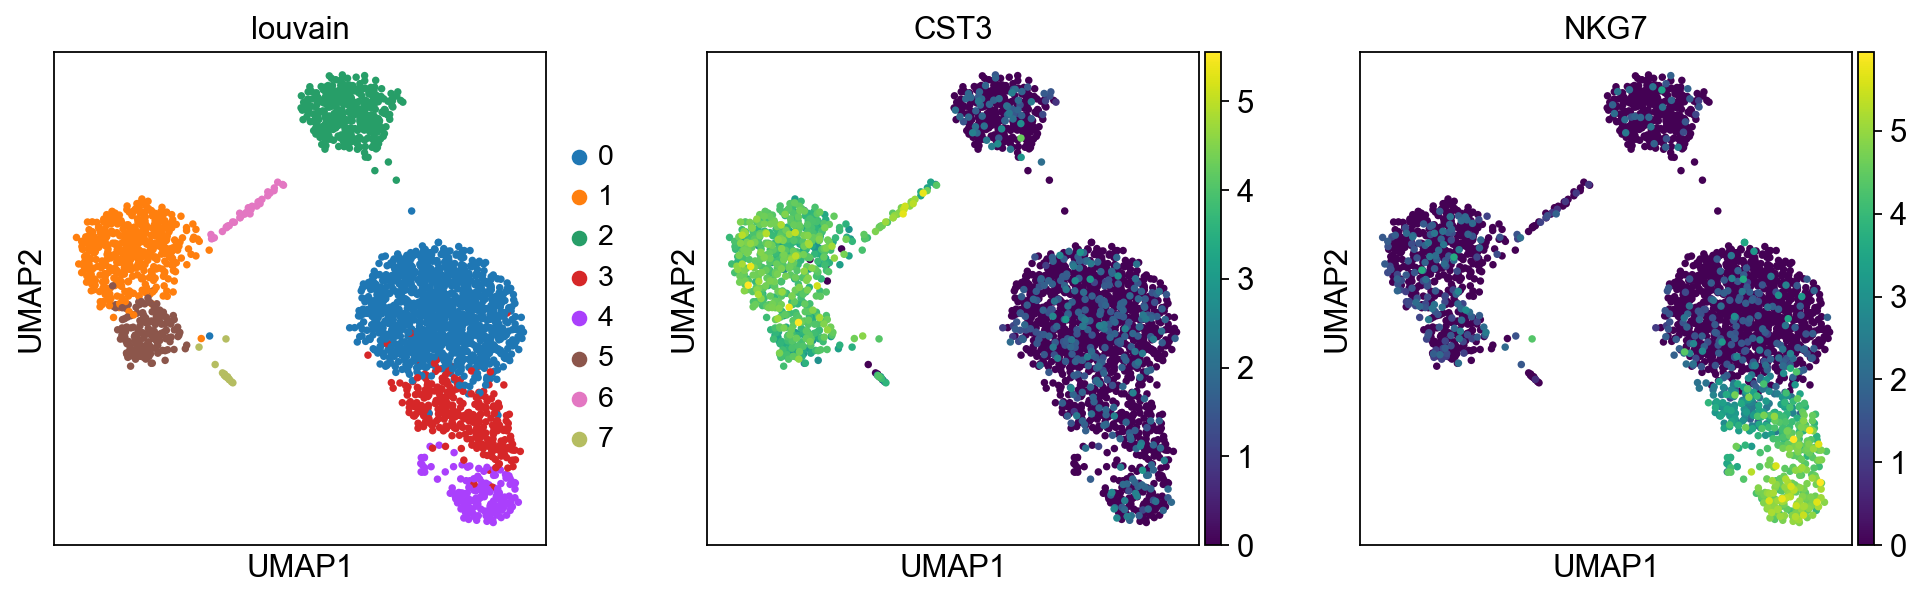

In [31]:
sc.pl.umap(adata, color=['louvain', 'CST3', 'NKG7'])

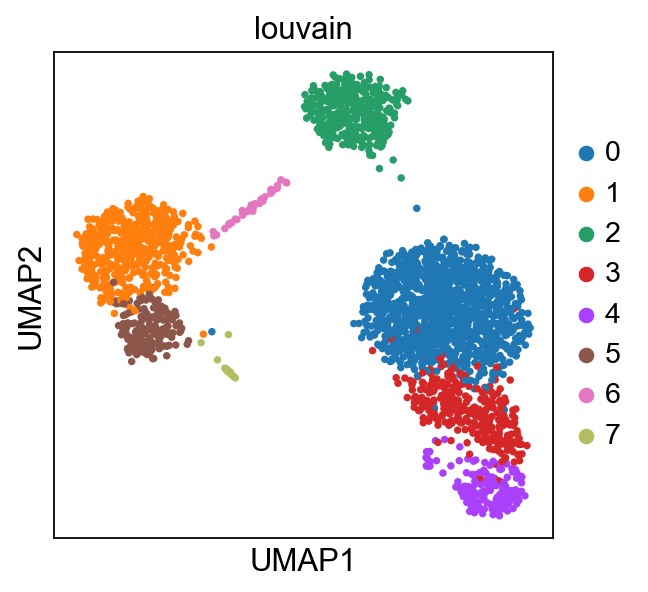

In [32]:
sc.pl.umap(adata, color=['louvain'])

Save the result.

In [33]:
adata.write(results_file)

**This is the end of the normal tutorial. The default values for clustering are KNN = 10 and Louvain resolution = 1**

## Evaluate clustering by varying KNN and Louvain resolution

I wanted to try out how changing KNN and Louvain resolution would affect the cluster number. Furthermore I wanted to use the two metrics Silhouette Coefficient and the Davies-Bouldin index to evalute the clustering result. The goal was to have some external evalutation methods that would make it easier to determine which clustering result is the "best" one. 

In [34]:
adata = sc.read(results_file)

In [35]:
## make loop trying out different KNN and Louvian resolutions and then save results in a dataframe.

from __future__ import print_function
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score
from tqdm import tnrange, tqdm_notebook
from time import sleep
import warnings


sc.settings.verbosity = 0   ### suppress output of scanpy
warnings.filterwarnings('ignore') # suppress Warnings
results_df=[]
results_df = pd.DataFrame(columns=['KNN', 'resolution','number_of_clusters', 'sil', 'davie_bould'])

for k in tnrange(5, 50, 5, desc ='1st loop'):
    sc.pp.neighbors(adata, n_neighbors=k, n_pcs=40);
    sc.tl.umap(adata);
    
    for i in tqdm_notebook(range(50, 150, 10), desc ='2nd loop', leave=False):
        j = i/100
        sc.tl.louvain(adata, resolution=j);
        adata.write(results_file);
        adata = sc.read(results_file);
        sc.tl.rank_genes_groups(adata, 'louvain')
        silhouette_avg = silhouette_score(adata.obsm['X_pca'], adata.obs['louvain'])
        davies_bouldin_avg = davies_bouldin_score(adata.obsm['X_pca'], adata.obs['louvain'])
        results_df = results_df.append(pd.DataFrame([[k, j, max(adata.obs['louvain']), silhouette_avg, davies_bouldin_avg]], columns=['KNN', 'resolution','number_of_clusters', 'sil', 'davie_bould']))
        sleep(0.01)
    

Print resulting the dataframe:

In [36]:
# need to change the object type louvain clusters are saved as object not float
# need to add 1 because it python starts counting at 0 and the total number of clusters is 1 + max

results_df['number_of_clusters'] = results_df['number_of_clusters'].astype(float) + 1 
results_df

,KNN,resolution,number_of_clusters,sil,davie_bould
0,5,0.5,6.0,0.166171,1.895271
0,5,0.6,6.0,0.162847,1.918729
0,5,0.7,6.0,0.164618,1.943305
0,5,0.8,7.0,0.136666,2.199004
0,5,0.9,8.0,0.136688,2.184243
0,5,1.0,8.0,0.033296,4.581122
0,5,1.1,10.0,0.035978,5.022618
0,5,1.2,10.0,0.033352,4.977730
0,5,1.3,10.0,0.029402,4.945484
0,5,1.4,10.0,0.028701,5.241986


Reformat the dataframe into more easily visualized tables that plots cluster number, Silhouette scores and Davies Bouldin index for different KNN (in the rows) and Louvain resolution (in the columns) combinations. 

**Cluster number:**

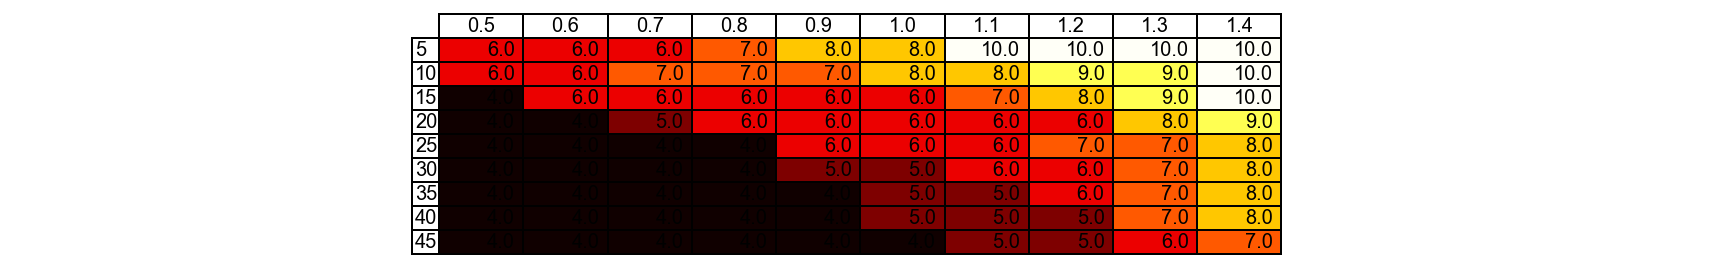

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

# Make a colored table with the number of clusters
piv_clust = results_df.pivot(index='KNN', columns='resolution', values='number_of_clusters')
vals = np.around(piv_clust.values,3) #evenly round to the given number of decimals.

norm = plt.Normalize(vals.min()-0.05, vals.max()+0.05)
colours = plt.cm.hot(norm(vals))

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(411, frameon=False, xticks=[], yticks=[])

the_table=plt.table(cellText=vals, rowLabels=piv_clust.index, colLabels=piv_clust.columns, 
                    colWidths = [0.05]*vals.shape[1], loc='center', 
                    cellColours=colours)
plt.show()

**Silhouette scores:**

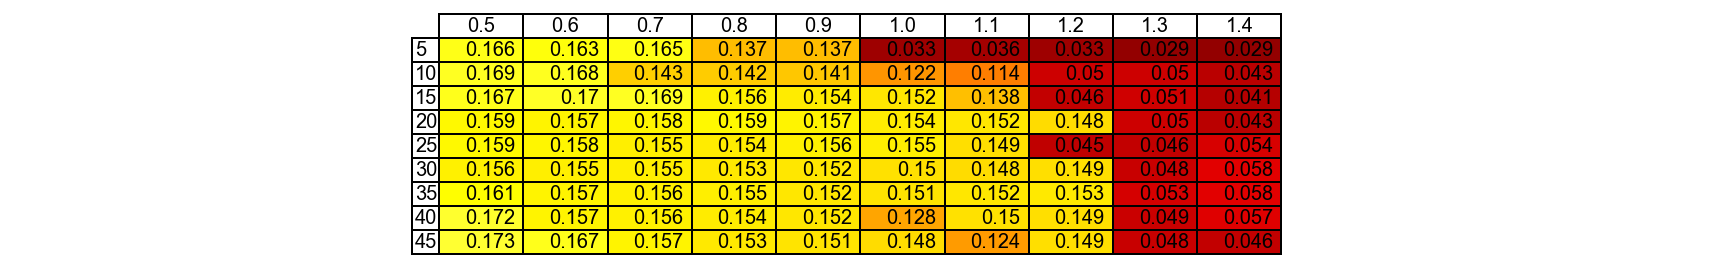

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

# Make a colored table with the silhouette scores
piv_sil = results_df.pivot(index='KNN', columns='resolution', values='sil')
vals = np.around(piv_sil.values,3) #evenly round to the given number of decimals.

norm = plt.Normalize(vals.min()-0.05, vals.max()+0.05)
colours = plt.cm.hot(norm(vals))

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(411, frameon=False, xticks=[], yticks=[])

the_table=plt.table(cellText=vals, rowLabels=piv_sil.index, colLabels=piv_sil.columns, 
                    colWidths = [0.05]*vals.shape[1], loc='center', 
                    cellColours=colours)
plt.show()

**Davies Bouldin index:**

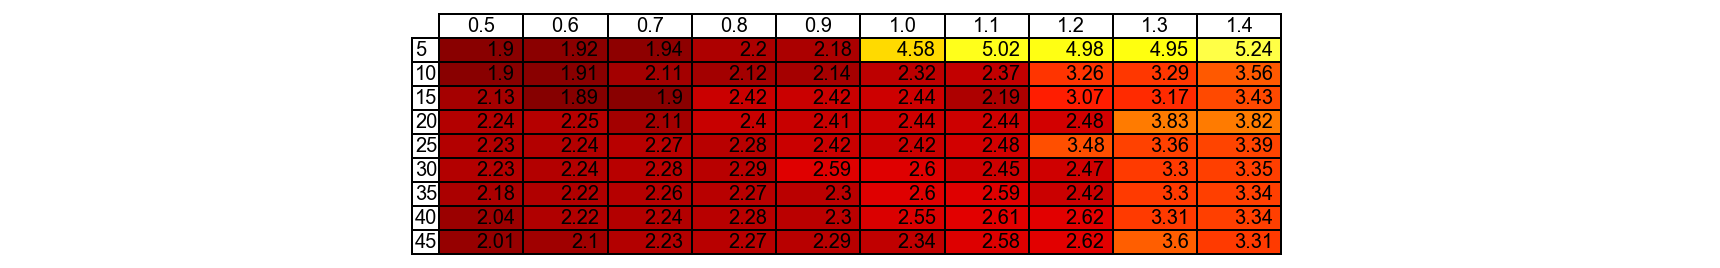

In [39]:
# Make a colored table with the Davies Bouldin index
piv_DB = results_df.pivot(index='KNN', columns='resolution', values='davie_bould')

vals = np.around(piv_DB.values,2) #evenly round to the given number of decimals.

norm = plt.Normalize(vals.min()-1, vals.max()+1)
colours = plt.cm.hot(norm(vals))


fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(411, frameon=False, xticks=[], yticks=[])

the_table=plt.table(cellText=vals, rowLabels=piv_DB.index, colLabels=piv_DB.columns, 
                    colWidths = [0.05]*vals.shape[1], loc='center', 
                    cellColours=colours)


plt.show()

Since it is difficult to find the optimal values in each of the tables plot find also the maximum value for the Silhuette score

In [40]:
# make some new dataframe for plotting
max_sil = results_df[results_df.groupby('number_of_clusters')['sil'].transform('max') 
          == results_df['sil']].sort_values(by=['number_of_clusters'])

min_db = results_df[results_df.groupby('number_of_clusters')['davie_bould'].transform('min') 
         == results_df['davie_bould']].sort_values(by=['number_of_clusters'])

Generate a graph that displays the top values for the Davies Bouldin index and Silhouette scores. This allows to pick the optimal cluster number.

<function matplotlib.pyplot.show(*args, **kw)>

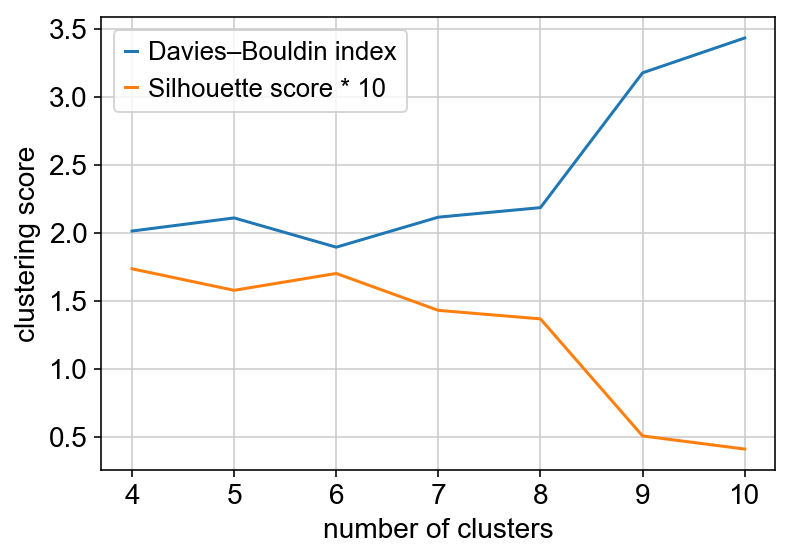

In [41]:
# plot the top value for each cluster

plt.plot(min_db['number_of_clusters'], min_db['davie_bould'])
plt.plot(max_sil['number_of_clusters'], min_db['sil'] * 10)
plt.legend(['Davies–Bouldin index','Silhouette score * 10'])
plt.xlabel('number of clusters')
plt.ylabel('clustering score')
plt.show

Looks like 8 clusters is the magic number! The scores are fairly stationary until 8 after which there is a big dropoff. When values are fairly stationary it is reasonable to look for the maximum number of clusters to get the most information about potential subpopulations within the dataset. The below table no lists the best KNN and resolution combination that gives the 8 clusters. 

In [42]:
results_df[results_df['number_of_clusters'] == 8].sort_values('sil', ascending=False) 

,KNN,resolution,number_of_clusters,sil,davie_bould
0,5,0.9,8.0,0.136688,2.184243
0,10,1.0,8.0,0.122235,2.323471
0,10,1.1,8.0,0.114418,2.370479
0,35,1.4,8.0,0.058171,3.344018
0,30,1.4,8.0,0.057548,3.348688
0,40,1.4,8.0,0.057163,3.344323
0,25,1.4,8.0,0.053615,3.391701
0,20,1.3,8.0,0.049606,3.830332
0,15,1.2,8.0,0.046298,3.071905
0,5,1.0,8.0,0.033296,4.581122


Now run through the top 3 KNN and resolution combinations and visually evalute the clustering

## Clustering #1 KNN = 5, resolution = 0.9 

perform the clustering for the top parameters and project into low dimensional space using the UMAP algorithm. 

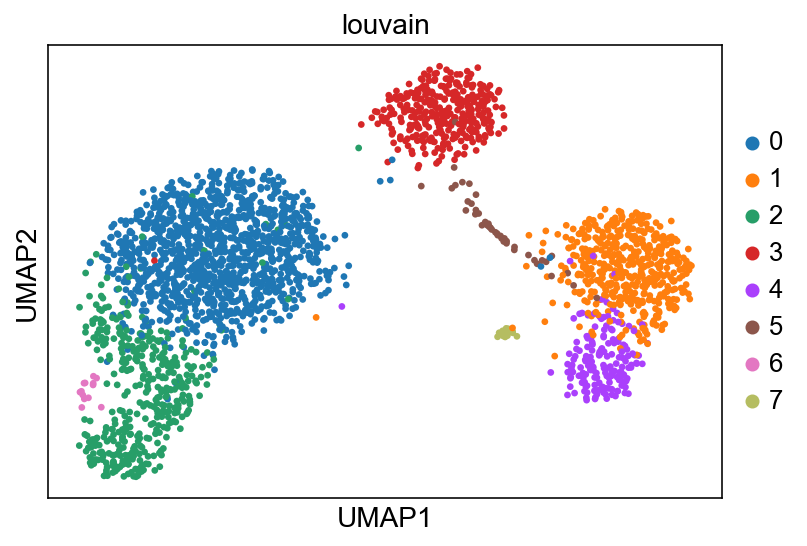

In [43]:
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=40)
sc.tl.louvain(adata, resolution=0.9)
sc.pl.umap(adata, color=['louvain'])
adata.write(results_file)

## Clustering #2 KNN = 10, resolution = 1.0

perform the clustering for the top parameters and project into low dimensional space using the UMAP algorithm. 

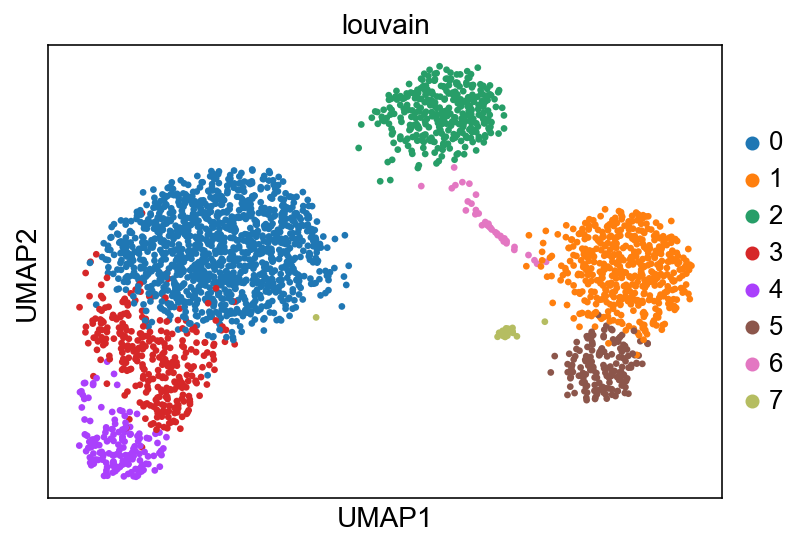

In [44]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.louvain(adata, resolution=1.0)
sc.pl.umap(adata, color=['louvain'])
adata.write(results_file)

## Clustering #3 KNN = 10, resolution = 1.1

perform the clustering for the top parameters and project into low dimensional space using the UMAP algorithm. 

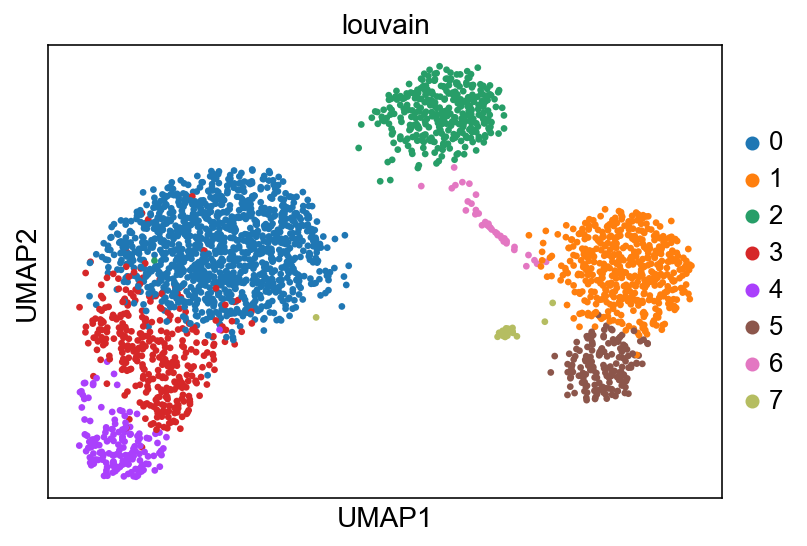

In [45]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.louvain(adata, resolution=1.1)
sc.pl.umap(adata, color=['louvain'])
adata.write(results_file)

To compare the above three top result also perform clustering with the lowest parameters from the table.

## Clustering #10 KNN = 5, resolution = 1.0

perform the clustering for the top parameters and project into low dimensional space using the UMAP algorithm. 

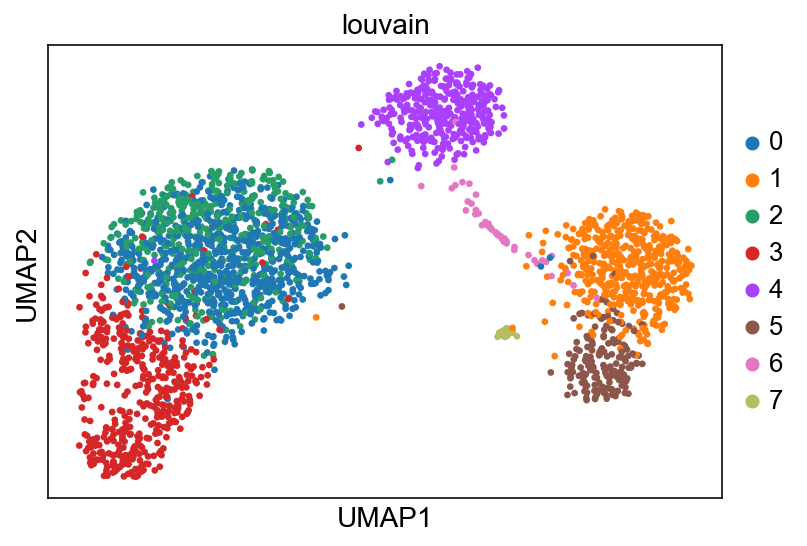

In [46]:
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=40)
sc.tl.louvain(adata, resolution=1.0)
sc.pl.umap(adata, color=['louvain'])
adata.write(results_file)

It looks like cells in cluster 0 and cluster 2 are intermixed